## Descriptive Analyses: how are users using their phone?

In [1]:
!pip install --upgrade matplotlib -q
!pip install --upgrade pandas -q
!pip install ipy mpl -q

ERROR: Could not find a version that satisfies the requirement mpl (from versions: none)
ERROR: No matching distribution found for mpl


In [2]:
class color:
   PURPLE, CYAN, DARKCYAN, BLUE = '\033[95m', '\033[96m', '\033[36m', '\033[94m'
   GREEN, YELLOW, RED, BOLD = '\033[92m', '\033[93m', '\033[91m','\033[1m'
   UNDERLINE, END = '\033[4m','\033[0m'

In [3]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.ticker as mtick
from string import ascii_letters
from scipy import stats
from sklearn import tree
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [4]:
demographics = pd.read_csv('Processed Data/demographics_15.csv')
demographics.rename(columns={'userid': 'id'}, inplace=True)
td_dataset = pd.read_stata('Raw Data/td_ita.dta')  #this version was filled - in with nan for unanswered timestamps. 
by_minute = pd.read_csv('Processed Data/by_minute_15_with_empty_obs.csv')
by_minute.touches = by_minute.touches.astype(int)
by_minute = by_minute.drop(columns="Unnamed: 0")

In [5]:
by_minute['timestamp'] = pd.to_datetime(by_minute.loc[:,'timestamp'])
by_minute.rename(columns={'userid': 'id'}, inplace=True)
dictdays = dict()
days = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

for i in range(0, 7):
    dictdays[i] = days[i]
by_minute.loc[:,"weekday"] = [days[i] for i in by_minute.timestamp.dt.weekday]
#dictdays[by_minute[by_minute.timestamp.dt.day == ].timestamp.head(1).dt.dayofweek.values[0]]
weekend_clock_days = [14, 15, 21, 22, 28]

#turning clock days to the observational time or "human days"
weekends = [by_minute[by_minute['timestamp'].dt.day == day].day.head(1).values[0] for day in weekend_clock_days]
print(weekends)  #the first weekend is 3 days into the observation. 
def today_or_yesterday(t): 
    if t < 0:
        return t + 24
    return t

[2, 3, 9, 10, 16]


Based on every time that an user said they were doing something, I need to find the activities that took the most time for them. 
Since my research question is about smartphone pervasiveness - how the smarthphone pervades students' everyday locations and activities - I need to know what students do for most of their time. 
This does require some categorization of students, but it won't be done with clustering techniques but through social categorical identities.

### Measures to make data compatible
Because of the 30 minutes time unit that is present in the time diary, the by_minute touches data will be grouped every 30 minutes for compatibility, and that users were consistent with their time diary data. Their touches data was already checked as consistent in the "Dataset preparation and cleaning" notebook.

In [6]:
# GROUPING.
chunk = by_minute.copy()
print('N users:', chunk.id.unique().shape[0])
shortened_times = pd.to_datetime(chunk['timestamp'], yearfirst=True).dt.floor('30T')
chunk.timestamp = shortened_times
df_grouped = chunk.groupby(['id','timestamp', 'weekday', 'day']).sum()  
df_grouped = df_grouped.reset_index()
print ('N users:',df_grouped.id.unique().shape[0])

N users: 147
N users: 147


In [7]:
df_grouped

id           timestamp weekday  day  touches
0         1 2020-11-10 00:00:00     Tue   -2        0
1         1 2020-11-10 00:30:00     Tue   -2        0
2         1 2020-11-10 01:00:00     Tue   -2        0
3         1 2020-11-10 01:30:00     Tue   -2        0
4         1 2020-11-10 02:00:00     Tue   -2        0
...     ...                 ...     ...  ...      ...
134059  264 2020-11-28 21:30:00     Sat   17     1258
134060  264 2020-11-28 22:00:00     Sat   17      903
134061  264 2020-11-28 22:30:00     Sat   17      823
134062  264 2020-11-28 23:00:00     Sat   17     1191
134063  264 2020-11-28 23:30:00     Sat   17      814

[134064 rows x 5 columns]

In [8]:
# CHECKING FOR CONSISTENCY

time_accurate = td_dataset[(td_dataset.date_not.dt.month == 11 
                         ) & (td_dataset.date_not.dt.day >= 13
                             ) & (td_dataset.date_not.dt.day <= 30)]
print(f'At first there are about {time_accurate.id.unique().shape[0]} users') 
IDs = time_accurate.id.unique()
user_activity = dict()
for ID in tqdm(IDs):
    id_act = time_accurate
    user_activity[ID] = list(id_act.date_not.dt.day.sort_values().unique())
print("User dictionary with sorted unique user-specific observation days is done.")

def gantt_data_org(k, v):
    ''' 
    gantt_data is named after the Gantt chart.
    S is the Series of days (regardless of when they start).
    '''
    tot = 0
    start = np.nan
    end = np.nan
    consecutive = False
    
    if len(v):  #if it's not empty, it will check for continuity
        tot = (pd.to_datetime(v[-1]) - pd.to_datetime(v[0])).days
        start, end = v[0], v[-1]
        
        for i in range(len(v)-1):
            v[i]  #current
            v[i+1] #next
            difference = (pd.to_datetime(v[i+1]) - pd.to_datetime(v[i])).days
            # if there is more than two days of difference it means that there was more than one
            # day in the data with no observations, and it is unlikely it's consistent data.
            if difference >= 2:    
                consecutive = False
                print(f"user {k} was not consistent.")
                break
            else:
                consecutive = True
                
    return pd.DataFrame([[k, start, end, tot, consecutive]], 
                        columns=['id', 'start', 'finish', 'tot', 'cons'])

gantt_data = pd.DataFrame(columns=["id", "start", "finish", "tot", "cons"])

for ID, days in user_activity.items():
    res = gantt_data_org(ID, days).dropna(axis=1, how='all')
    gantt_data = pd.concat([gantt_data, res], ignore_index=True)
print("The test is finished.")
print("We end up with: N = ", gantt_data.id.unique().shape[0])
to_keep = gantt_data[gantt_data['cons'] == True].id
time_accurate.rename(columns={'date_not': 'timestamp'}, inplace=True)
td_consistent = time_accurate[time_accurate.id.isin(to_keep)]

At first there are about 241 users


100%|████████████████████████████████████████| 241/241 [00:01<00:00, 172.61it/s]
/tmp/ipykernel_7059/2154888851.py:48: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  gantt_data = pd.concat([gantt_data, res], ignore_index=True)


User dictionary with sorted unique user-specific observation days is done.
The test is finished.
We end up with: N =  241


/tmp/ipykernel_7059/2154888851.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_accurate.rename(columns={'date_not': 'timestamp'}, inplace=True)


In [9]:
print("IDs in time diary", td_consistent.id.unique().shape[0])
print("IDs in touch sensor data", df_grouped.id.unique().shape[0])
print("Difference of IDs is", len(set(td_consistent.id.unique()) - set(df_grouped.id.unique())))

IDs in time diary 241
IDs in touch sensor data 147
Difference of IDs is 94


In [10]:
df = pd.merge(pd.merge(df_grouped, td_consistent, on=['id', 'timestamp'], how='left'), demographics[[
    'id','w1_A01', 'department','cohort', 'MExtraversion', 'MAgreeableness', 'MConscientiousness', 'MNeuroticism',
       'MOpenness']], on = ['id'])
df.id.unique().shape[0]

145

In [11]:
l3 = ['id', 'timestamp', 'weekday', 'day', 'touches', 'pilot', 'week', 'what', 
      'travel_fromto', 'travel_medium', 'sport', 'where', 'withw', 'mood',
       'delta_td', 'answerduration_td', 'sleep', 'expectday', 'delta_mo', 'tag_ev', 
      'howwasday', 'uniproblem', 'evtot', 'delta_ev', 'A6b', 'delta_sn',
      'tm', 'w1_A01', 'department', 'cohort',  'delta_td', 'answerduration_td', 'delta_mo', 'evtot', 'delta_ev', 'delta_sn', 'MExtraversion', 'MAgreeableness', 'MConscientiousness', 'MNeuroticism']

datatype = dict()
for el in l3:
    type=0
    if df[f'{el}'].dtype == 'category' or df[f'{el}'].dtype == 'object':
        if df[f'{el}'].dtype == 'object':
            df[f'{el}'] = df[f'{el}'].astype('category')
        if 'No information' not in df[f'{el}'].cat.categories:
            df[f'{el}'] = df[f'{el}'].cat.add_categories('No information')
        df[f"{el}"].fillna("No information", inplace=True)
        type = 'category'
        
    elif df[f'{el}'].dtype == "int32" or  df[f'{el}'].dtype == "int64" or df[f'{el}'].dtype == 'float32' or df[f'{el}'].dtype == "float64" :
        df[f"{el}"].fillna(0, inplace=True)
        type='int_float'
        
    elif df[f'{el}'].dtype == "datetime64[ns]":
        df[f"{el}"].fillna("No information", inplace=True)
        type='datetime'
    else: 
        print(el, df[f'{el}'].dtype)
    if type not in datatype.keys():
        datatype[type] = [el]
    else:
        datatype[type].append(el)
        
df.hh_not = df.timestamp.dt.hour + df.timestamp.dt.minute / 60
df.day = df.timestamp.dt.weekday

In [12]:
df[(df.withw != 'Alone') & (df.withw != 'No information') & (df.withw != 'Not answer')].shape[0]   # 33.126
df[(df.withw == 'Alone') | (df.withw == 'No information') | (df.withw == 'Not answer')].shape[0]   # 99.114

99114

In [13]:
print(f"Total rows of the first three datasets: {df_grouped.shape[0]:,}; {td_consistent.shape[0]:,}; {demographics.shape[0]}")
print(f"Total rows of resulting dataset: {df.shape[0]:,}")
df.to_csv("Processed Data/df_touch_td_demo.csv")

Total rows of the first three datasets: 134,064; 204,850; 145
Total rows of resulting dataset: 132,240


In [14]:
l = "YY_not, MM_not, DD_not, hh_not, mm_not, tdtot, delta_td, answerduration_td, motot, delta_mo, answerduration_mo, evtot, delta_ev, answerduration_ev, sntot, delta_sn, answerduration_sn, c3mis, b6mis, c6mis".split(",")
l = [i.strip() for i in l]
# for i in l:
    #print(df[f'{i}'].unique())

l2 = "datein_ques", "datein_answ", "first2w", "YY_not", "MM_not", "DD_not", "hh_not", "mm_not", "tag_td", "A3c", "tdtot",  "tag_mo", "motot", "answerduration_ev","answerduration_mo", "answerduration_ev", "answerduration_sn", "tag_sn", "A6c", "sntot", "what1", "what2", "where2", "withw2", "c3mis", 'c3_1',  'c3_2', 'c3_3', 'c3_4', 'c3_5', 'c3_6', 'c3_7', 'c3_8', 'c3_9', 'c3_10', 'c3_11', 'c3_12', 'c3_13', 'c3_14', 'c3_15', 'c3_16', 'c3_17', 'c3_18', 'c3_19', 'c3_20', "b6mis", "c6mis",  'b6_1',  'b6_2', 'b6_3', 'b6_4', 'b6_5', 'c6_1', 'c6_2', 'c6_3', 'c6_4', 'c6_5', 'c6_6', 'c6_7', 'c6_8', 'c6_9', 'c6_10', 'c6_11', 'c6_12', 'c6_13', 'c6_14', 'c6_15', 'c6_16', 'c6_17', 'c6_18', 'c6_19', 'c6_20', 'c6_21', 'c6_22', 'c6_23', 'c6_24', 'c6_25', 'c6_26'
l3
# for el in l3:
#     print(f"{color.BOLD}{el}{color.END}")
#     print(df[f"{el}"].unique())
df.day.unique()
# sns.histplot(x= "delta_td",y= "what", data=df.sort_values(by='delta_td'))

array([1, 2, 3, 4, 5, 6, 0], dtype=int32)

In [15]:
l1 = ["c3_"]*21
l1 = [l1[i] + f"{i}" for i in range(1, len(l1))]
df.cohort.value_counts().sort_index()
p1 = (17328 + 22800 + 19152)/df.cohort.value_counts().sort_index().sum()
print(p1)
# df.department.value_counts()
p2 = (32832 + 30096 + 20064 )/df.department.value_counts().sum()
print(p2)
(p1 + p2 )/2

0.4482758620689655
0.6275862068965518


0.5379310344827586

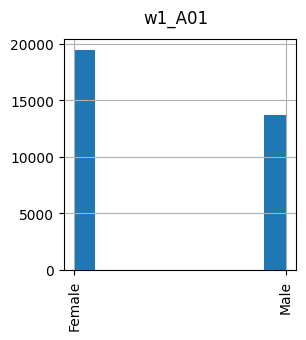

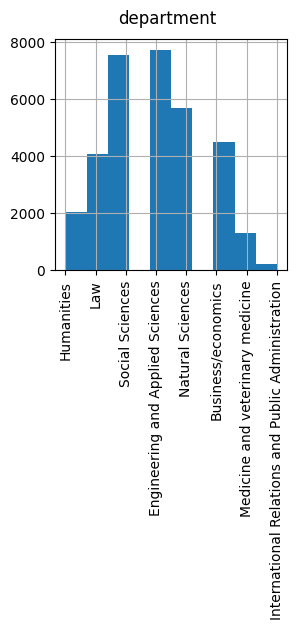

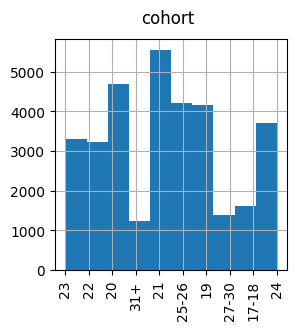

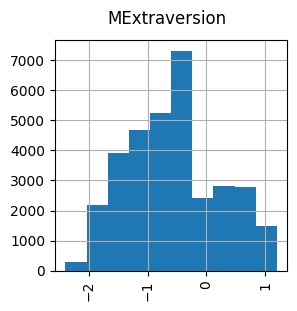

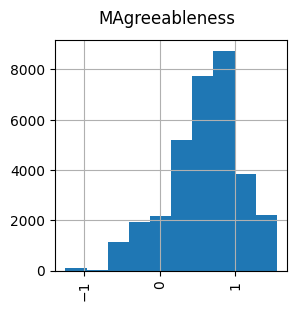

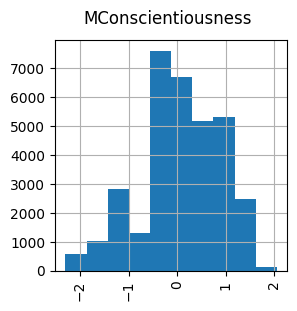

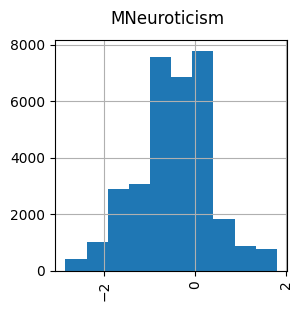

In [16]:
for i in ['w1_A01', 'department','cohort', 'MExtraversion', 'MAgreeableness', 'MConscientiousness', 'MNeuroticism']:
    fig = plt.subplots(figsize=(3,3))
    df[(df.withw != 'Alone') & (df.withw != 'No information') & (df.withw != 'Not answer')][f'{i}'].hist()
    plt.suptitle(f'{i}')
    plt.xticks(rotation=90)
    plt.show()
    

In [17]:
df.touches.median

<bound method Series.median of 0            0
1            0
2            0
3            0
4            0
          ... 
132235    1258
132236     903
132237     823
132238    1191
132239     814
Name: touches, Length: 132240, dtype: int64>

/tmp/ipykernel_7059/145363189.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sns.scatterplot(data=df.groupby('cohort').agg({'touches':'mean'}), x='cohort', y='touches')


<Axes: xlabel='cohort', ylabel='touches'>

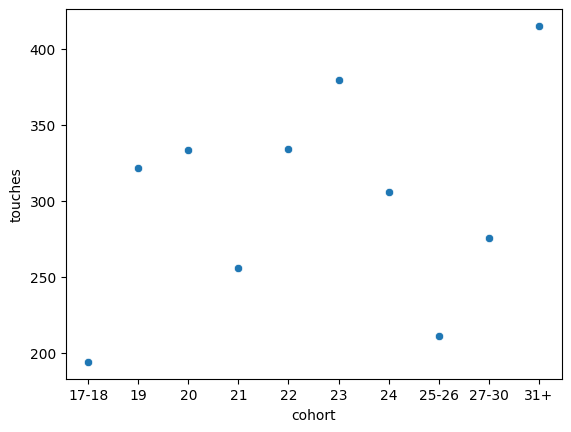

In [18]:
sns.scatterplot(data=df.groupby('cohort').agg({'touches':'mean'}), x='cohort', y='touches')

# Time series from clustering

/tmp/ipykernel_7059/1284799307.py:1: DtypeWarning: Columns (107) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('Processed Data/df_touch_td_demo.csv')
/tmp/ipykernel_7059/1284799307.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[df.touches > 1800].touches = np.nan  #more than one touch per second (or 1800 per 30 minutes) becomes meaningless


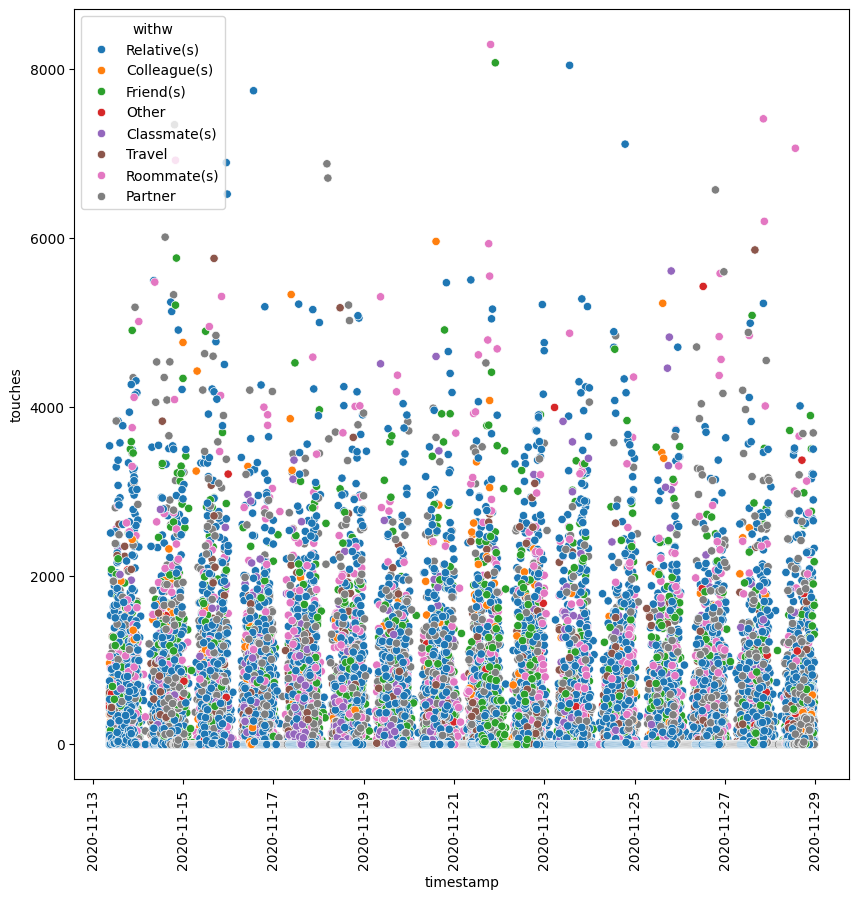

In [19]:
df = pd.read_csv('Processed Data/df_touch_td_demo.csv')
df.timestamp = pd.to_datetime(df.timestamp)

df[df.touches > 1800].touches = np.nan  #more than one touch per second (or 1800 per 30 minutes) becomes meaningless

df.touches.fillna(df.touches.median(), inplace=True) 

cluster_table = pd.read_csv('Processed Data/cluster_table.csv')
# Keep in mind: these "profiles" are clustered deriving from a subset of 33.126 observations
# regarding users who were WITH SOMEBODY, and dropped NAs.
cluster_table
with_somebody = df[(df.withw != 'Alone') & (df.withw != 'No information') & (df.withw != 'Not answer') & (df.withw != 'Expired')]
plt.subplots(figsize=(10,10))
sns.scatterplot(data=with_somebody,
               x='timestamp',
               y='touches', hue="withw")
plt.xticks(rotation=90)
plt.show()

##### From Kruskal-Wallis test analyses ... 
As shown in the table directly below, it appears that some categorical variables hold a significant effect towards the quantitative "touches" when selecting by 

- activity ("what")
- cohort
- department  
- location ("where")
- company ("withw")
- hour ("hh_not")
And others, but to a lesser degree. By mistake, there is "withw" twice in the table.

This test is used to indicate how much of a significant change in the data when studying the effect on a quantitative variable by these listed attributes, without parameters (differently from ANOVA) but still under the assumption of independency of variance.


For the purpose of this research, different combinations of "what" and "withw" and "cohort" will be used, the first two because of their relevance to the research question, but also because there seem to be generational differences in phone usage. 

In [20]:
table1 = pd.read_csv('Processed Data/table1.csv')
table2 = pd.read_csv('Processed Data/table2.csv')
table1

Variable        p.value  Kruskal.Wallis.chi.squared
0       withw   2.522445e-45                  226.676344
1        what  3.945250e-120                  668.526243
2         sex   4.995387e-04                   12.117386
3      cohort  4.224835e-123                  598.579835
4  department   2.371748e-80                  390.683798

##### From Dunn test post-hoc analyses...
This test is used to compare all the modalities inside a categorical variable against each other, regardless of direction, on the basis of their effect on a quantative variable. 

In the table below one can see the results of the Dunn test conducted on the categorical variables, as post-hoc Kruskal Wallis analysis. It does not represent the full list of results but only the most significant comparison (for simplicity), For each categorical variable tested above, the comparison with the highest value on the Dunn Test statistic is chosen, and its p-value is also reported. 

When a variable has only two modes, it is going to compare the two against each other only. 


In [21]:
table2

Variable                               Comparison       P.value  \
0       withw                Partner  vs.  Relative(s)  2.176842e-28   
1        what  Did not do anything special  vs.  Games  1.423376e-41   
2         sex                        Female  vs.  Male  4.995387e-04   
3      cohort                           17-18  vs.  20  9.691191e-80   
4  department        Humanities  vs.  Natural Sciences  3.340002e-51   

   Dunn.test.statistic  
0            11.345875  
1           -13.961012  
2            -3.481004  
3            19.108303  
4           -15.271024

I will compare 17-18 vs 20 year olds in their touchscreen usage, and in the same fashion I will compare "Partner vs Relative". Interestingly enough, from the dunn test results any comparison that included 17-18 vs the rest were also the strongest statistic - meaning that's the most different cohort from the others. I put a screenshot below of this. 

**Cohort dunn test: strongest 9 comparisons**


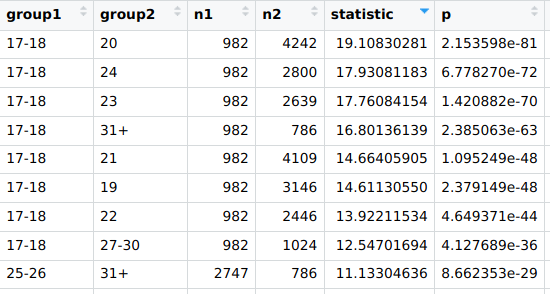


In [22]:
df[df.cohort.isna()]

Empty DataFrame
Columns: [Unnamed: 0, id, timestamp, weekday, day, touches, pilot, datein_ques, datein_answ, first2w, week, YY_not, MM_not, DD_not, hh_not, mm_not, tag_td, what, travel_fromto, travel_medium, sport, A3c, where, withw, mood, tdtot, delta_td, answerduration_td, tag_mo, sleep, expectday, motot, delta_mo, answerduration_mo, tag_ev, howwasday, uniproblem, evtot, delta_ev, answerduration_ev, tag_sn, A6b, A6c, sntot, delta_sn, answerduration_sn, tm, what1, what2, where2, withw2, c3mis, c3_1, c3_2, c3_3, c3_4, c3_5, c3_6, c3_7, c3_8, c3_9, c3_10, c3_11, c3_12, c3_13, c3_14, c3_15, c3_16, c3_17, c3_18, c3_19, c3_20, b6mis, b6_1, b6_2, b6_3, b6_4, b6_5, c6mis, c6_1, c6_2, c6_3, c6_4, c6_5, c6_6, c6_7, c6_8, c6_9, c6_10, c6_11, c6_12, c6_13, c6_14, c6_15, c6_16, c6_17, c6_18, c6_19, c6_20, c6_21, ...]
Index: []

[0 rows x 113 columns]

In [23]:
cluster0 = df
cluster0 = cluster0.groupby(['cohort','hh_not',pd.Grouper(key='day')])['touches'].mean().reset_index().copy(deep=True)
cluster0.day = cluster0.loc[:,"day"]*24 + cluster0.loc[:,'hh_not']
cohort_meantouch = dict()
all_cohorts = list(set(df.cohort.unique().astype('str')))
all_cohorts.sort()
for el in all_cohorts:
    cohort_meantouch[f'{el}'] = dict({'Mean' :round(cluster0[cluster0.cohort == f"{el}"].touches.mean(), 0), 'N' : cluster0[cluster0.cohort == f"{el}"].shape[0]})
print('Mean touches (in ANY situation, ANY time) across cohorts:')
cohort_meantouch


Mean touches (in ANY situation, ANY time) across cohorts:


{'17-18': {'Mean': 196.0, 'N': 336},
 '19': {'Mean': 334.0, 'N': 336},
 '20': {'Mean': 289.0, 'N': 336},
 '21': {'Mean': 256.0, 'N': 336},
 '22': {'Mean': 318.0, 'N': 336},
 '23': {'Mean': 388.0, 'N': 336},
 '24': {'Mean': 317.0, 'N': 336},
 '25-26': {'Mean': 213.0, 'N': 336},
 '27-30': {'Mean': 280.0, 'N': 336},
 '31+': {'Mean': 419.0, 'N': 336}}

In [24]:
with_somebody[(with_somebody.cohort == '27-30')].withw.value_counts(normalize=True) 

withw
Partner         0.456664
Relative(s)     0.307356
Roommate(s)     0.089585
Classmate(s)    0.060452
Friend(s)       0.056082
Colleague(s)    0.018208
Other           0.011653
Name: proportion, dtype: float64

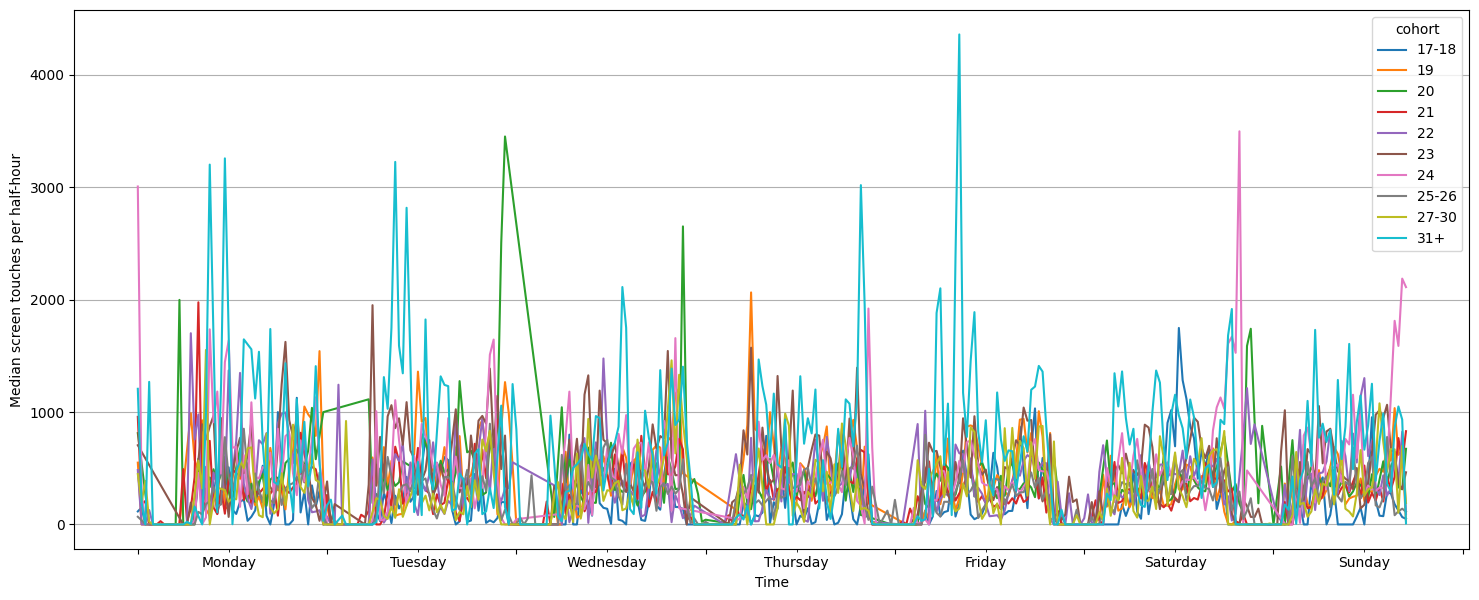

In [25]:
# Selecting the clusters of people based on their attributes
cluster0 = with_somebody
cluster0 = cluster0.groupby(['cohort','hh_not',pd.Grouper(key='day')])['touches'].mean().reset_index().copy(deep=True)
cluster0.day = cluster0.loc[:,"day"]*24 + cluster0.loc[:,'hh_not']

figure, ax = plt.subplots(figsize=(18,7))

sns.lineplot(data=cluster0[(cluster0.cohort == '17-18') | (cluster0.cohort == '19')  |
             (cluster0.cohort == '20') | 
             (cluster0.cohort == '21') | (cluster0.cohort == '22') | (cluster0.cohort == '23') |
             (cluster0.cohort == '24') | (cluster0.cohort == '25-26') |  (cluster0.cohort == '27-30') | 
             (cluster0.cohort == '31+') 
             ], x='day', y='touches', hue='cohort', estimator='mean', errorbar=('se',1),  seed=25)

ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(12, 168+12, 25)))
ax.xaxis.set_minor_formatter(ticker.FixedFormatter(['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']))
plt.ylabel('Median screen touches per half-hour')
plt.xlabel('Time')
plt.grid(axis='y')
plt.show()

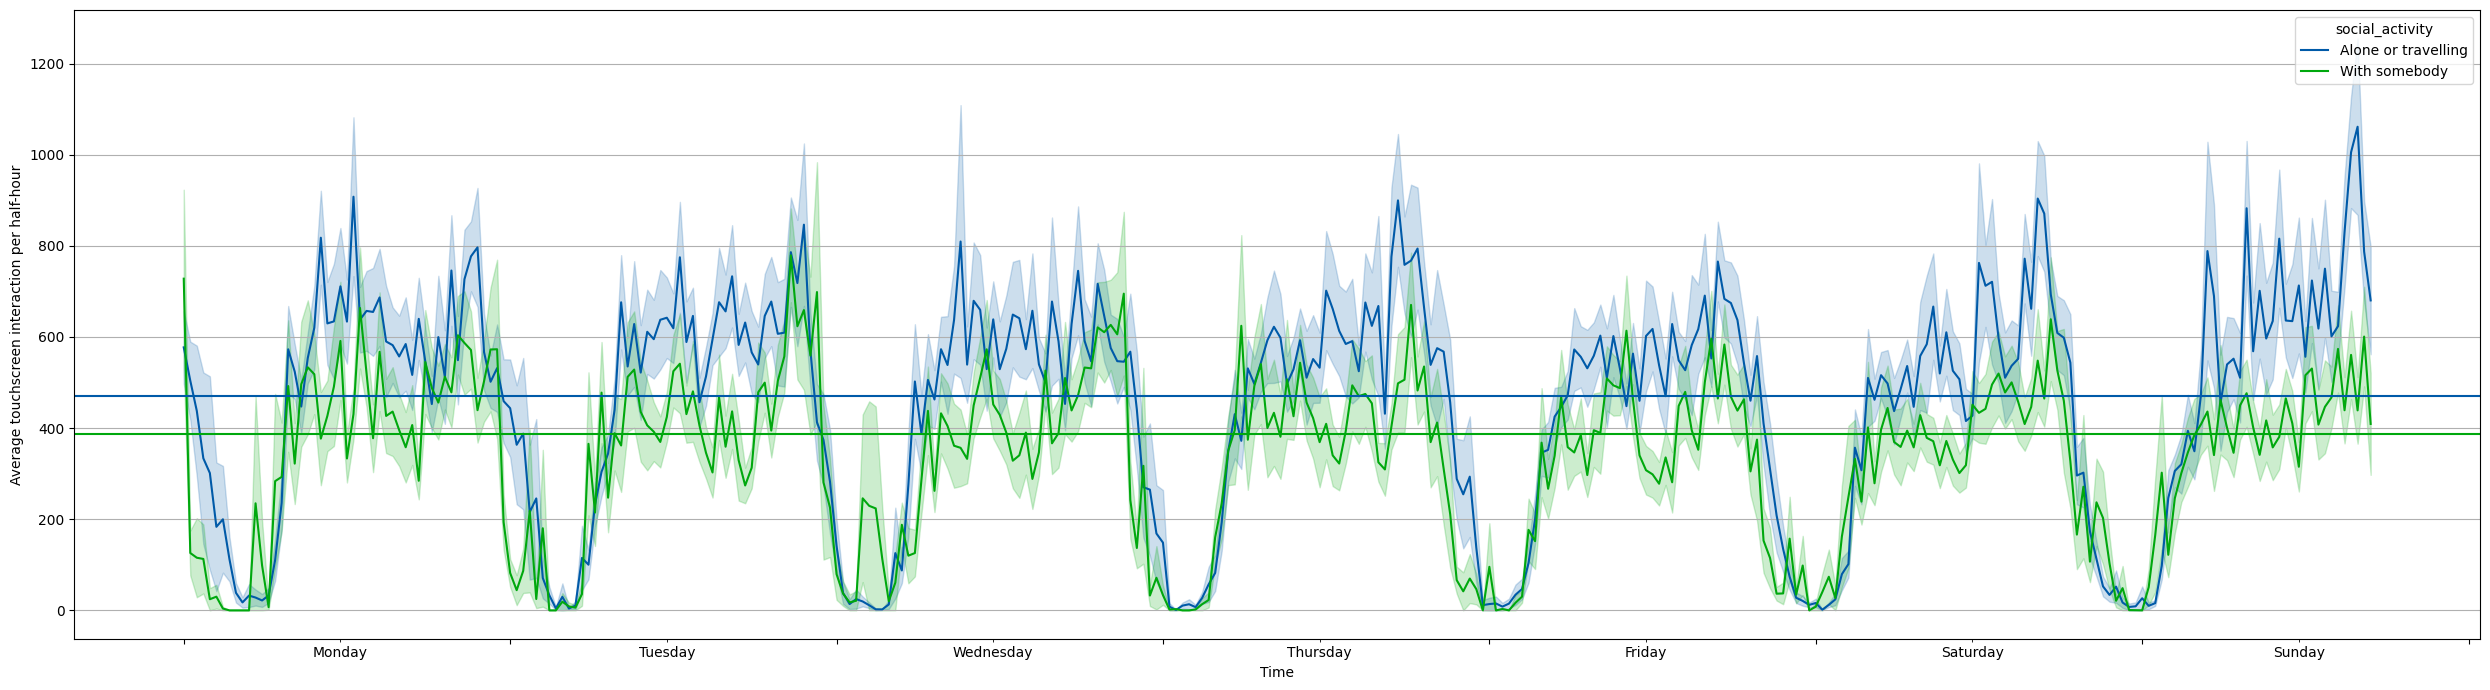

In [140]:
cluster1 = df[(df.withw != 'No information') & (df.withw != 'Not answer') & (df.withw != 'Expired')]
cluster1 = cluster1.groupby(['cohort','hh_not','withw',pd.Grouper(key='day')])['touches'].mean().reset_index().copy(deep=True)
cluster1.day = cluster1.loc[:,"day"]*24 + cluster1.loc[:,'hh_not']
cluster1['social_activity'] = cluster1.withw.isin(['Partner', 'Relative(s)', 'Roommate(s)', 'Classmate(s)', 'Friend(s)', 'Colleague(s)', 'Other'])
cluster1.social_activity = ["With somebody" if booolean else "Alone or travelling" for booolean in cluster1.social_activity]

figure, axes = plt.subplots(1, 1, figsize=(25,7), sharey=True, sharex=True)
sns.lineplot(data=cluster1, x='day', y='touches', hue='social_activity', estimator='mean', errorbar=('se',1),  seed=25,
            palette=sns.color_palette(['#005aa8', '#00a80e']))
axes.axhline(y=round(cluster1[cluster1.social_activity == 'With somebody'].touches.mean(), 0), color='#00a80e')
axes.axhline(y=round(cluster1[cluster1.social_activity == 'Alone or travelling'].touches.mean(), 0), color='#005aa8')
axes.xaxis.set_major_formatter(ticker.NullFormatter())
axes.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(12, 168+12, 25)))
axes.xaxis.set_minor_formatter(ticker.FixedFormatter(['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']))
plt.xlabel('Time')
plt.ylabel('Average touchscreen interaction per half-hour')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("Graphs/phone_usage_oneweek.pdf", dpi=1000)
plt.show()


In [141]:
cluster1['hh_not'] = (cluster1['hh_not'] - 5)
def rearranging_hours(t): 
    if t < 0:
        return t + 24
    else:
        return t
cluster1['hh_not'] = [rearranging_hours(hour) for hour in cluster1['hh_not']]

custom_order = ['5:00', ' ', '6:00', ' ', '7:00', ' ', '8:00', ' ', 
                '9:00', ' ', '10:00', ' ', '11:00', ' ', '12:00', ' ', 
                '13:00', ' ', '14:00', ' ', '15:00', ' ', '16:00', ' ', 
                '17:00', ' ', '18:00', ' ', '19:00', ' ', '20:00', ' ', 
                '21:00', ' ','22:00', ' ', '23:00', ' ', '0:00', ' ', '1:00', ' ', 
                '2:00', ' ', '3:00', ' ', '4:00', ' ', '5:00']
cluster1.head(3)

cohort  hh_not  withw   day     touches      social_activity
0     19    19.0  Alone   0.0  635.666667  Alone or travelling
1     19    19.0  Alone  24.0  388.000000  Alone or travelling
2     19    19.0  Alone  48.0  868.000000  Alone or travelling

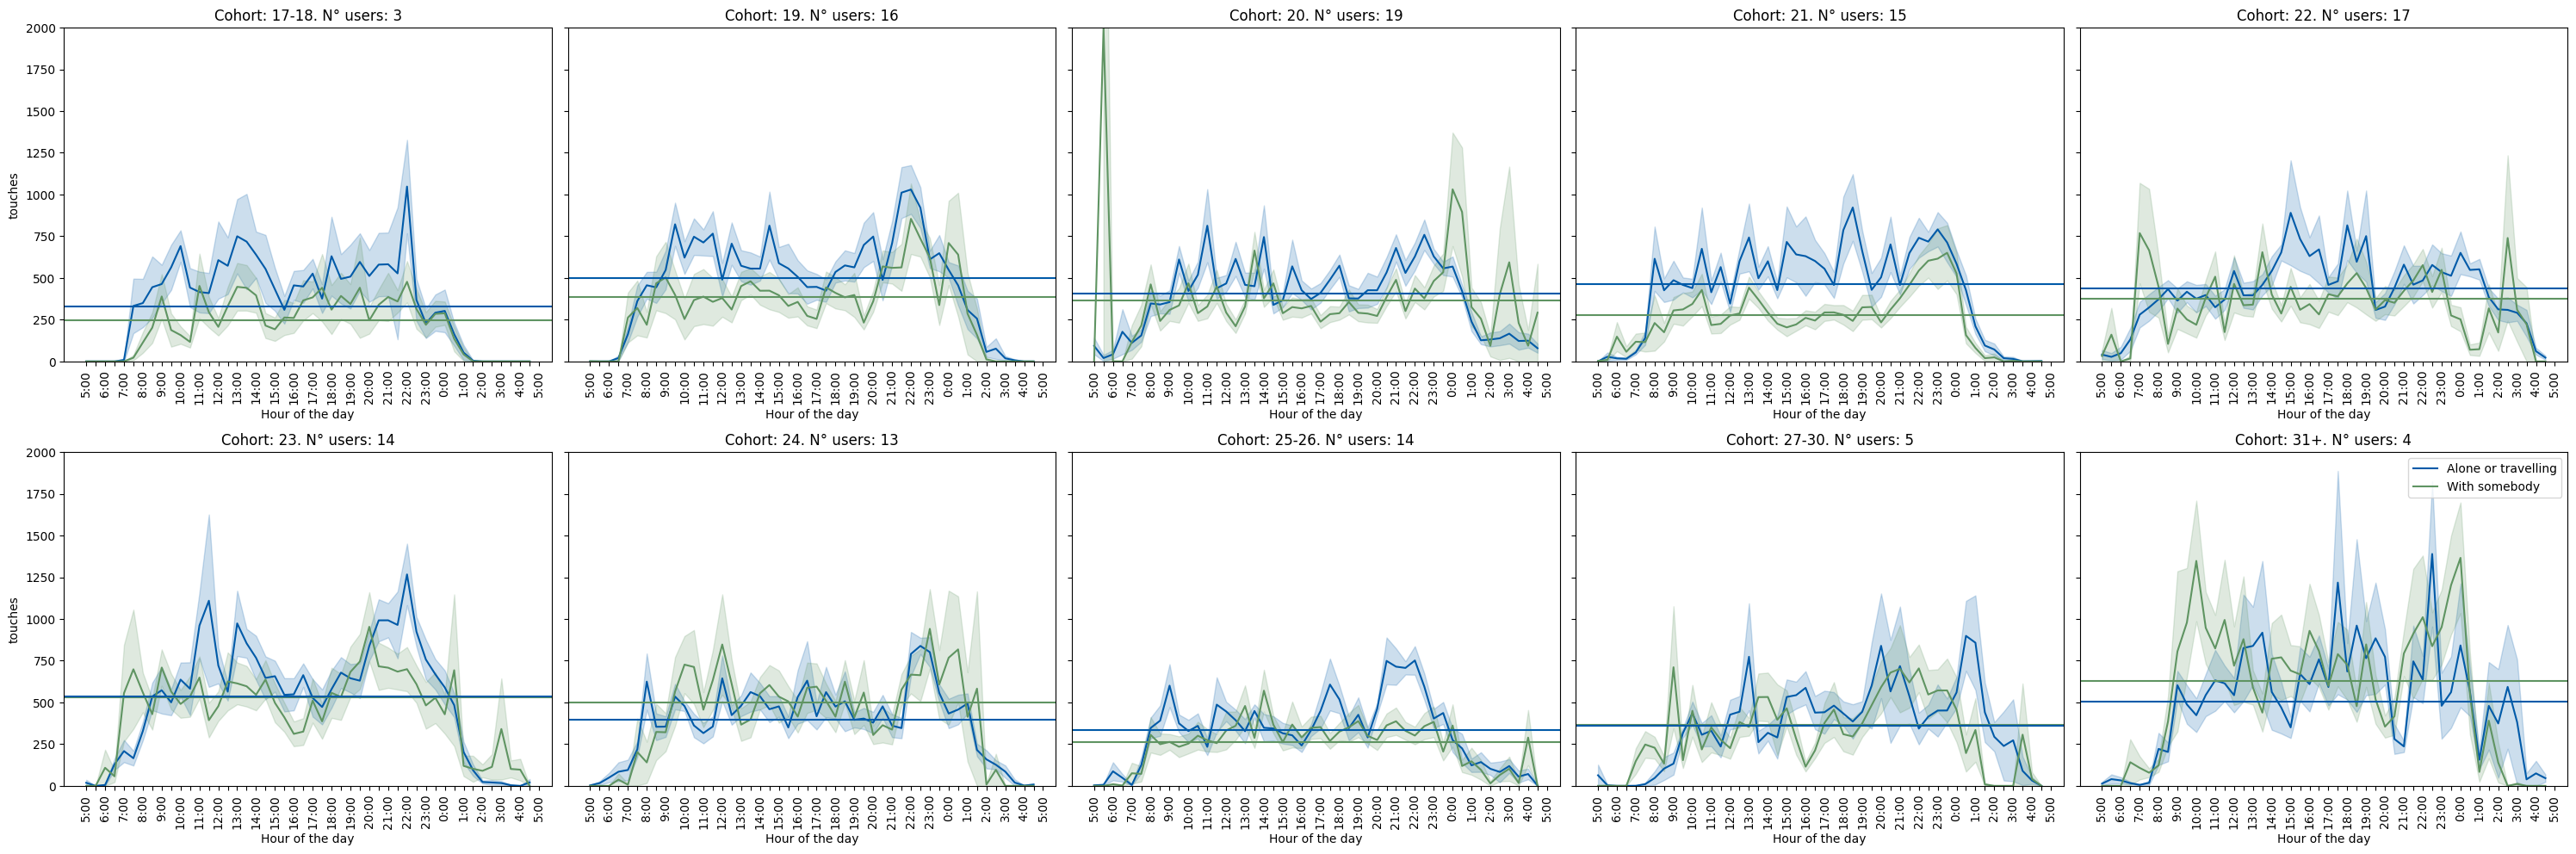

In [150]:
figure, axes = plt.subplots(2, 5, figsize=(30,10), sharey=True)
axes = axes.flatten()
for cohort in range(len(all_cohorts)):
    sns.lineplot(data=cluster1[(cluster1.cohort == f'{all_cohorts[cohort]}')], x='hh_not', y='touches', hue='social_activity', estimator='mean', errorbar=('se',1),  seed=25,
            palette=sns.color_palette(['#005aa8', '#5f9462']), ax=axes[cohort], legend=cohort==9)
    axes[cohort].axhline(y=round(cluster1[(cluster1.social_activity == 'With somebody') & (cluster1.cohort == f'{all_cohorts[cohort]}')].touches.mean(), 0), color='#5f9462')
    axes[cohort].axhline(y=round(cluster1[(cluster1.social_activity == 'Alone or travelling') & (cluster1.cohort == f'{all_cohorts[cohort]}')].touches.mean(), 0), color='#005aa8')
    axes[cohort].xaxis.set_major_formatter(ticker.NullFormatter())
    axes[cohort].set_xticks(np.arange(len(custom_order))/2)
    axes[cohort].set_xticklabels(custom_order, rotation=90)
    axes[cohort].set_title(f"Cohort: {all_cohorts[cohort]}. N° users: { df[df['cohort'].isin([all_cohorts[cohort]])].id.unique().shape[0] }")
    axes[cohort].set_ylim(0, 2000)
    # axes[cohort].margins(x=-0.019)
    axes[cohort].set_xlabel("Hour of the day")
plt.tight_layout(pad=1.0)
plt.legend()
plt.savefig("Graphs/phone_socialactivity_bycohort.pdf", dpi=1000)
plt.show()

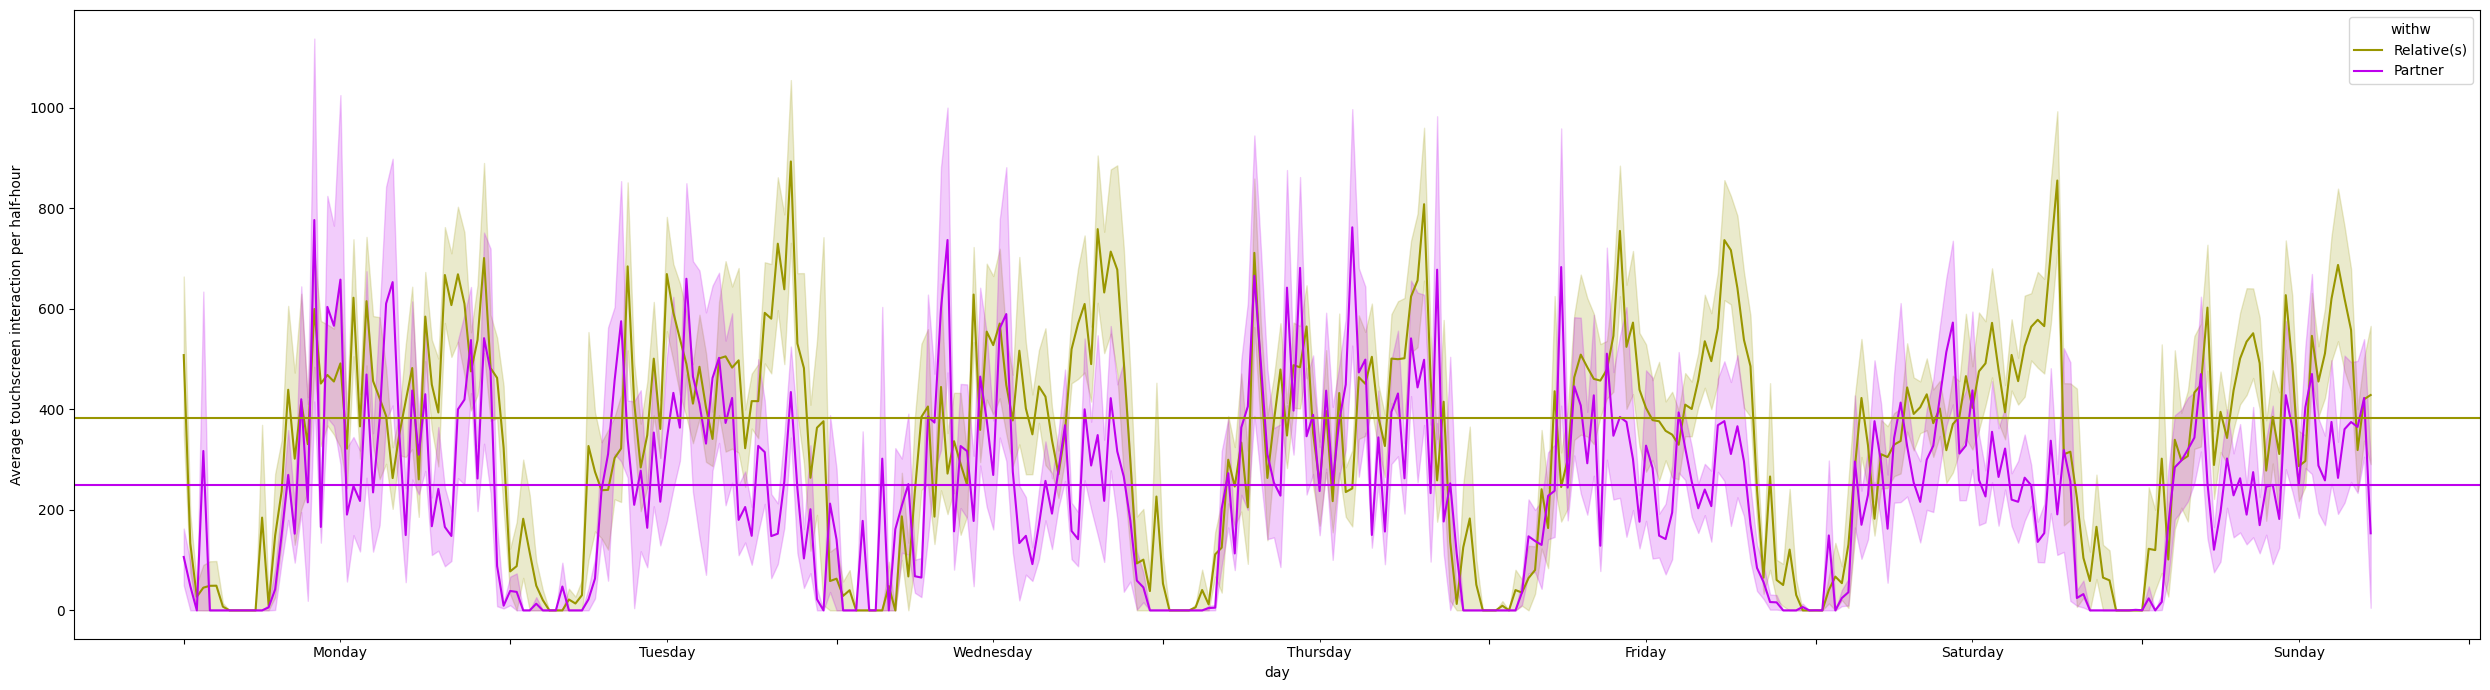

In [151]:
cluster2 = df[(df.withw != 'No information') & (df.withw != 'Not answer') & (df.withw != 'Expired')]

cluster2 = cluster2.groupby(['cohort','hh_not','withw',pd.Grouper(key='day')])['touches'].mean().reset_index().copy(deep=True)
cluster2.day = cluster2.loc[:,"day"]*24 + cluster2.loc[:,'hh_not']
cluster2 = cluster2[cluster2.touches < 2000]

display_only = ['Partner', 'Relative(s)'] #'Colleague(s)','Classmate(s)', 'Other' 'Friend(s)', 'Alone', 'Travel'


figure, axes = plt.subplots(1, 1, figsize=(25,7), sharey=True)
sns.lineplot(data=cluster2[cluster2.withw.isin(display_only)], x='day', y='touches', hue='withw', estimator='mean', errorbar=('se',1),  seed=25,
            palette=sns.color_palette([\
                                      # 'blue'
                                      '#999600', 
                                      '#be00ed', 
                                      # '#00b4e0',
                                      # '#e00400',
                                      # '#00e022',
                                      # '#000000'
                                      ])
            )
# axes.axhline(y=round(cluster2[cluster2.withw == 'Alone'].touches.mean(), 0), color='blue') #deep blue
axes.axhline(y=round(cluster2[cluster2.withw == 'Relative(s)'].touches.mean(), 0), color='#999600') #yellowish  
axes.axhline(y=round(cluster2[cluster2.withw == 'Partner'].touches.mean(), 0), color='#be00ed')     #purple
# axes.axhline(y=round(cluster2[cluster2.withw == 'Colleague(s)'].touches.mean(), 0), color='#00b4e0')     #light blue
# axes.axhline(y=round(cluster2[cluster2.withw == 'Friend(s)'].touches.mean(), 0), color='#e00400')     #red
# axes.axhline(y=round(cluster2[cluster2.withw == 'Classmate(s)'].touches.mean(), 0), color='#00e022')  #green
# axes.axhline(y=round(cluster2[cluster2.withw == 'Other'].touches.mean(), 0), color='#000000')     #black

axes.xaxis.set_major_formatter(ticker.NullFormatter())
axes.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(12, 168+12, 25)))
axes.xaxis.set_minor_formatter(ticker.FixedFormatter(['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']))
plt.ylabel('Average touchscreen interaction per half-hour')
plt.tight_layout()
plt.savefig('Graphs/partner_vs_relative.pdf', dpi=1000)
plt.show()


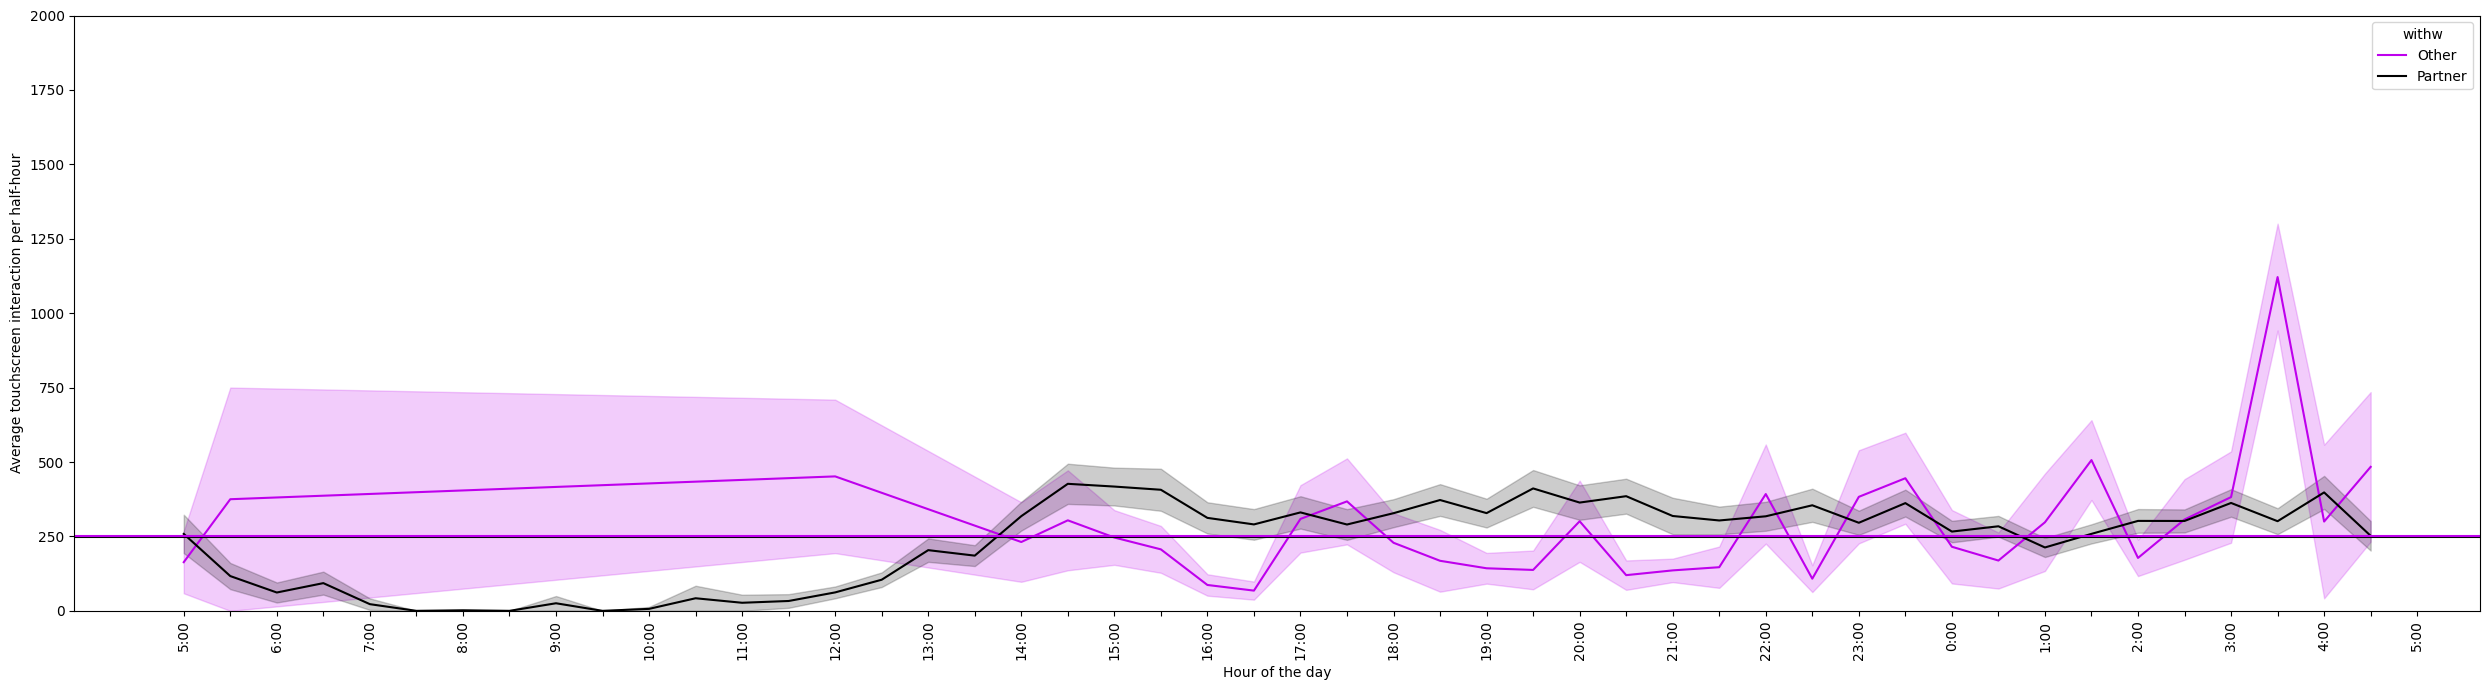

In [208]:
cluster2 = df[(df.withw != 'No information') & (df.withw != 'Not answer') & (df.withw != 'Expired')]

cluster2 = cluster2.groupby(['cohort','hh_not','withw',pd.Grouper(key='day')])['touches'].mean().reset_index().copy(deep=True)
cluster2.day = cluster2.loc[:,"day"]*24 + cluster2.loc[:,'hh_not']
cluster2 = cluster2[cluster2.touches < 2000]

display_only = ['Partner', 'Other'] #'Colleague(s)','Classmate(s)', 'Other' 'Friend(s)', 'Alone', 'Travel'
figure, axes = plt.subplots(1, 1, figsize=(25,7), sharey=True)
sns.lineplot(data=cluster2[cluster2.withw.isin(display_only)], x='hh_not', y='touches', hue='withw', estimator='mean', errorbar=('se',1),  seed=25,
            palette=sns.color_palette([\
                                      # 'blue'
                                      # '#999600', 
                                      '#be00ed', 
                                      # '#00b4e0',
                                      # '#e00400',
                                      # '#00e022',
                                      '#000000'
                                      ]))


axes.axhline(y=round(cluster2[cluster2.withw == 'Other'].touches.mean(), 0), color='#000000')     #black
axes.axhline(y=round(cluster2[cluster2.withw == 'Partner'].touches.mean(), 0), color='#be00ed')     #purple
axes.xaxis.set_major_formatter(ticker.NullFormatter())
axes.set_xticks(np.arange(len(custom_order))/2)
axes.set_xticklabels(custom_order, rotation=90)
axes.set_ylim(0, 2000)
    # axes[cohort].margins(x=-0.019)
axes.set_xlabel("Hour of the day")
plt.ylabel('Average touchscreen interaction per half-hour')
plt.tight_layout()
plt.savefig('Graphs/partner_vs_other.pdf')
plt.show()

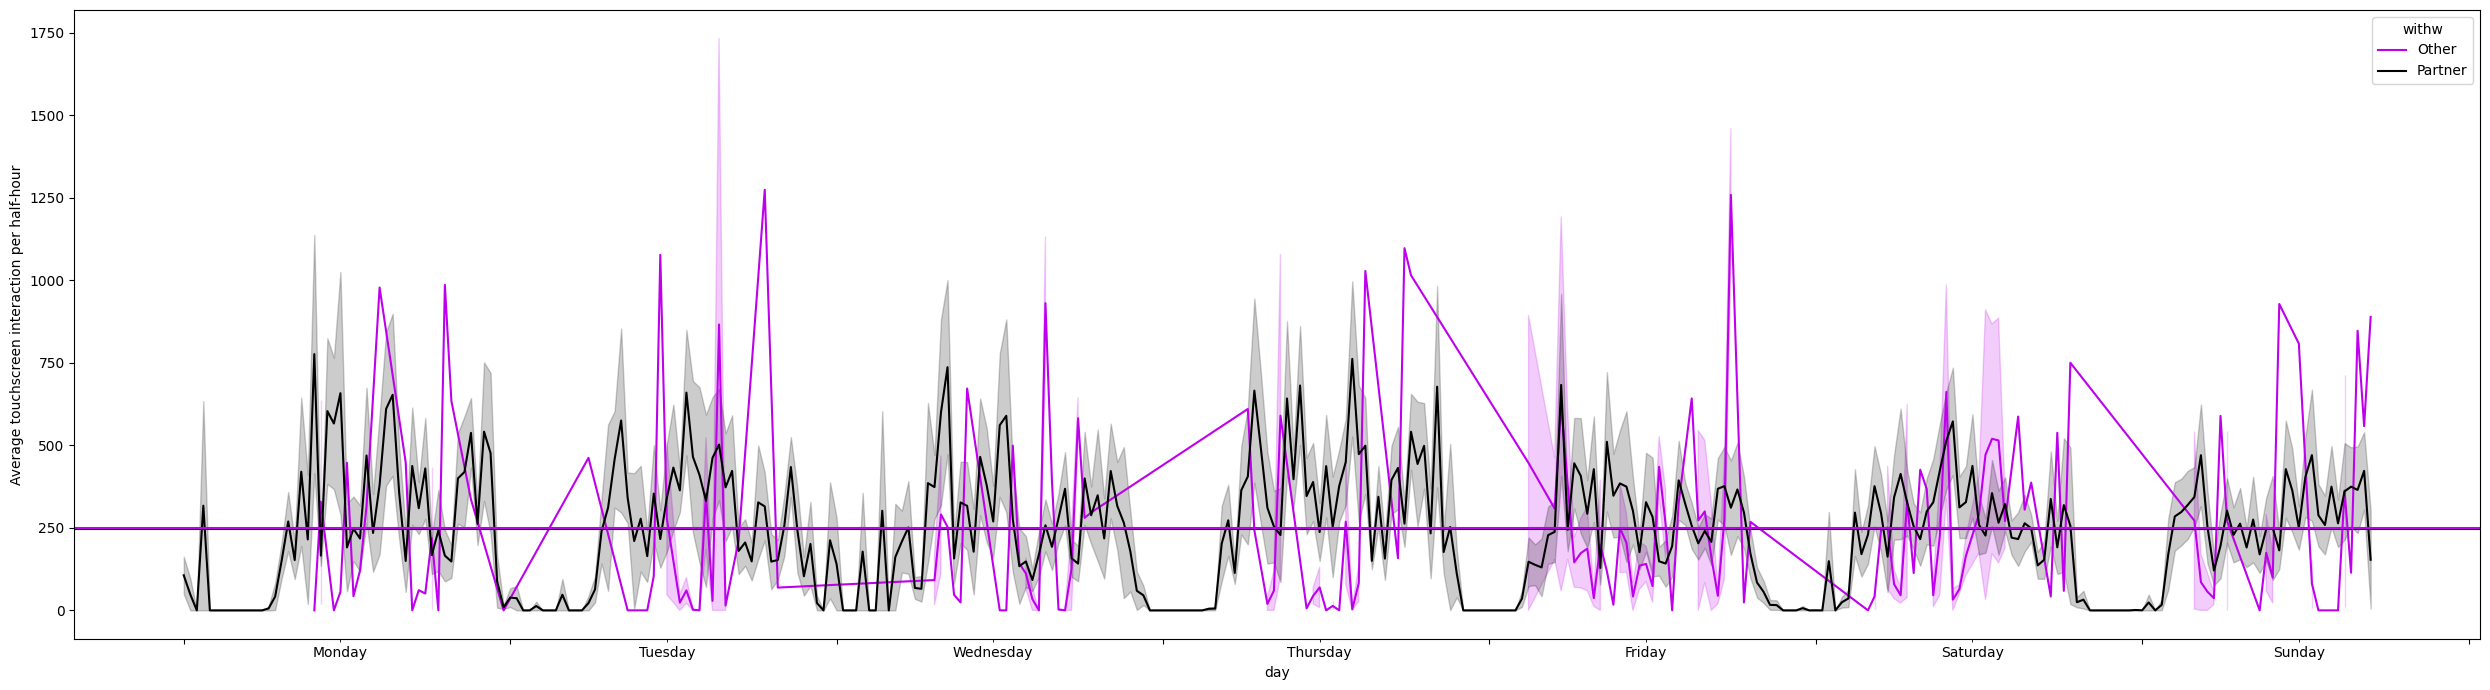

In [46]:
cluster2 = df[(df.withw != 'No information') & (df.withw != 'Not answer') & (df.withw != 'Expired')]

cluster2 = cluster2.groupby(['cohort','hh_not','withw',pd.Grouper(key='day')])['touches'].mean().reset_index().copy(deep=True)
cluster2.day = cluster2.loc[:,"day"]*24 + cluster2.loc[:,'hh_not']
cluster2 = cluster2[cluster2.touches < 2000]

display_only = ['Partner', 'Other'] #'Colleague(s)','Classmate(s)', 'Other' 'Friend(s)', 'Alone', 'Travel'


figure, axes = plt.subplots(1, 1, figsize=(25,7), sharey=True)
sns.lineplot(data=cluster2[cluster2.withw.isin(display_only)], x='day', y='touches', hue='withw', estimator='mean', errorbar=('se',1),  seed=25,
            palette=sns.color_palette([\
                                      # 'blue'
                                      # '#999600', 
                                      '#be00ed', 
                                      # '#00b4e0',
                                      # '#e00400',
                                      # '#00e022',
                                      '#000000'
                                      ])
            )
# axes.axhline(y=round(cluster2[cluster2.withw == 'Alone'].touches.mean(), 0), color='blue') #deep blue
# axes.axhline(y=round(cluster2[cluster2.withw == 'Relative(s)'].touches.mean(), 0), color='#999600') #yellowish

# axes.axhline(y=round(cluster2[cluster2.withw == 'Colleague(s)'].touches.mean(), 0), color='#00b4e0')     #light blue
# axes.axhline(y=round(cluster2[cluster2.withw == 'Friend(s)'].touches.mean(), 0), color='#e00400')     #red
# axes.axhline(y=round(cluster2[cluster2.withw == 'Classmate(s)'].touches.mean(), 0), color='#00e022')  #green
axes.axhline(y=round(cluster2[cluster2.withw == 'Other'].touches.mean(), 0), color='#000000')     #black 
axes.axhline(y=round(cluster2[cluster2.withw == 'Partner'].touches.mean(), 0), color='#be00ed')     #purple

axes.xaxis.set_major_formatter(ticker.NullFormatter())
axes.xaxis.set_minor_locator(ticker.FixedLocator(np.arange(12, 168+12, 25)))
axes.xaxis.set_minor_formatter(ticker.FixedFormatter(['Monday', 'Tuesday', 'Wednesday','Thursday', 'Friday', 'Saturday', 'Sunday']))
plt.ylabel('Average touchscreen interaction per half-hour')
plt.tight_layout()
plt.savefig('Graphs/partner_vs_relative.png')
plt.show()


In [30]:
df[df.withw == 'Other'].id.unique()[pd.Series(df[df.withw == 'Other'].id.unique()).isin(df[df.withw == 'Partner'].id.unique())]

array([ 12,  22,  28,  42,  45,  62,  72,  80,  84,  86, 119, 120, 124,
       137, 157, 159, 163, 174, 188, 196, 208, 216, 228, 232, 251])

In [31]:
df[df.withw == 'Other'].what.value_counts(normalize=True)

what
Other                                            0.161765
Voluntary work, and participatory activities     0.114706
Walking                                          0.091176
Free Time Study                                  0.088235
Work                                             0.082353
Personal care                                    0.076471
Social life                                      0.064706
Phone/Video calling                              0.058824
Sport                                            0.038235
Study/work group                                 0.032353
Others Entertainment and Culture                 0.026471
Hobbies                                          0.023529
Watching TV, video, YouTube, etc.                0.023529
Household and family care                        0.020588
Break (coffee, cigarette, drink, etc.)           0.017647
Eating                                           0.014706
Entertainment Exhibit, and Culture               0.014706
Did not d

In [32]:
df[df.withw == 'Partner'].what.value_counts(normalize=True)

what
Sleeping                                          0.267378
Study/work group                                  0.124798
Watching TV, video, YouTube, etc.                 0.094407
Eating                                            0.089880
Social life                                       0.073876
Did not do anything special                       0.058681
Walking                                           0.027966
Lecture/seminar/conference/university meeting     0.027643
Rest/nap                                          0.027643
Cooking, Food preparation & management            0.023925
Household and family care                         0.021662
Games                                             0.020692
Phone/Video calling                               0.016812
Work                                              0.015842
Break (coffee, cigarette, drink, etc.)            0.014872
Other                                             0.013902
Personal care                                     0

In [37]:
df[df.withw == 'Other']['where']

260                In the street
313               Relatives Home
698                In the street
791                In the street
1177      House (friends others)
                   ...          
124881      Home apartment /room
128852      Another indoor place
128853      Another indoor place
128854      Another indoor place
128855      Another indoor place
Name: where, Length: 340, dtype: object

# Statistical information

In [73]:
import math
import scipy.stats as st

In [198]:
df = df[(df.withw != 'No information') & (df.withw != 'Not answer') & (df.withw != 'Expired')]
print('observations', df.shape[0])
print('alone', df[df.withw.isin(['Partner', 'Relative(s)', 'Roommate(s)', 'Classmate(s)', 'Friend(s)', 'Colleague(s)', 'Other'])].shape[0])
print('with somebody', df[~df.withw.isin(['Partner', 'Relative(s)', 'Roommate(s)', 'Classmate(s)', 'Friend(s)', 'Colleague(s)', 'Other'])].shape[0])
print('users', df.id.unique().shape[0])

observations 79779
alone 28812
with somebody 50967
users 145


In [71]:
print(cluster1[cluster1.social_activity == "With somebody"].touches.mean())  # 387
print(cluster1[cluster1.social_activity == "Alone or travelling"].touches.mean())  #471

386.9473854274112
471.28837189931204


- Calculate the Standard Deviation
- Determine the Z-score for the Desired Confidence Level: at 99%, Z = 2.58
- Calculate the Margin of Error (MOE)
- Calculate the Confidence Interval:
CI = Observed Percentage ± MOE

In [88]:
alone = cluster1[cluster1.social_activity == "Alone or travelling"].touches.mean()
with_somebody = cluster1[cluster1.social_activity == "With somebody"].touches.mean()

SD = cluster1[cluster1.social_activity == "Alone or travelling"].touches.std()

n = cluster1[cluster1.social_activity == "Alone or travelling"].touches.shape[0]
C = 0.99  # 99%
alpha = 1 - C
tails = 2
q = 1 - (alpha / tails) #quantile
dof = n - 1 # Degrees of freedom
# Critical t-statistic
t_star = st.t.ppf(q, dof)

ci_upper = alone + t_star * SD / np.sqrt(n)
ci_lower = alone - t_star * SD / np.sqrt(n)

print(f'At 99% confidence level, the true mean for "alone" lies between {ci_lower:4.1f} and {ci_upper:5.1f}. CI levels difference: {ci_upper-ci_lower:4.1f}')

SD = cluster1[cluster1.social_activity == "With somebody"].touches.std()

n = cluster1[cluster1.social_activity == "With somebody"].touches.shape[0]
C = 0.99  # 99%
alpha = 1 - C
tails = 2
q = 1 - (alpha / tails) #quantile
dof = n - 1 # Degrees of freedom
# Critical t-statistic
t_star = st.t.ppf(q, dof)

ci_upper = with_somebody + t_star * SD / np.sqrt(n)
ci_lower = with_somebody - t_star * SD / np.sqrt(n)

print(f'At 99% confidence level, the true mean for "with somebody" lies between {ci_lower:4.1f} and {ci_upper:5.1f}. CI levels difference: {ci_upper-ci_lower:4.1f}')

At 99% confidence level, the true mean for "alone" lies between 455.6 and 486.9. CI levels difference: 31.3
At 99% confidence level, the true mean for "with somebody" lies between 373.6 and 400.3. CI levels difference: 26.6


In [147]:
df.id.value_counts().mean()

550.2

In [155]:
display_only

['Partner', 'Relative(s)']

In [197]:
print(df[df.withw == 'Partner'].shape[0])
print(df[df.withw == 'Relative(s)'].shape[0])
print(df[df.withw.isin(display_only)].id.unique().shape[0])
print(df[df.withw=='Relative(s)'].id.unique().shape[0])
print(df[df.withw=='Partner'].id.unique().shape[0])

6186
13151
131
124
57


In [167]:
pip install matplotlib-venn -q

Note: you may need to restart the kernel to use updated packages.


In [174]:
from matplotlib_venn import venn2  
from matplotlib_venn import venn3

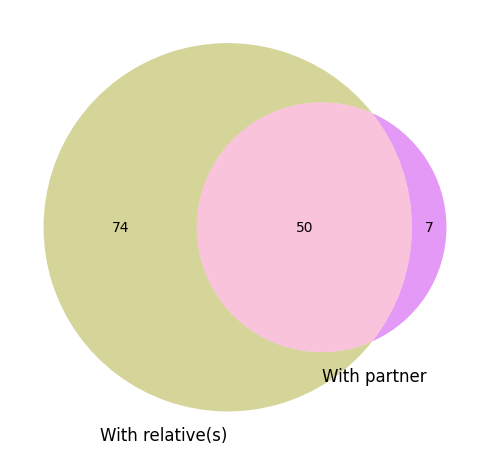

In [196]:
figure, ax = plt.subplots(1, 1, figsize=[5, 5])
set1 = set(df[df.withw=='Relative(s)'].id)
set2 = set(df[df.withw=='Partner'].id)
venn_labels = {'100': f'Total Set 1: {len(set1)}', '010': f'Total Set 2: {len(set2)}', '001': f'Shared: {len(set1 & set2)}'} 
venn2(subsets=(len(set1 - set2), len(set2 - set1), len(set1 & set2)), set_labels=('With relative(s)', 'With partner'), set_colors=('#999600', '#be00ed'))
plt.tight_layout()
plt.savefig("Graphs/venndiagram.pdf", dpi=1000)
plt.show()

In [202]:
df[df.withw == 'Other'].shape[0]
df[df.withw == 'Partner'].shape[0]

6186

In [199]:
df.withw.unique()

array(['Relative(s)', 'Alone', 'Colleague(s)', 'Friend(s)', 'Other',
       'Classmate(s)', 'Travel', 'Roommate(s)', 'Partner'], dtype=object)

In [213]:
df[df.withw=='Other'].id.unique().shape[0]

61

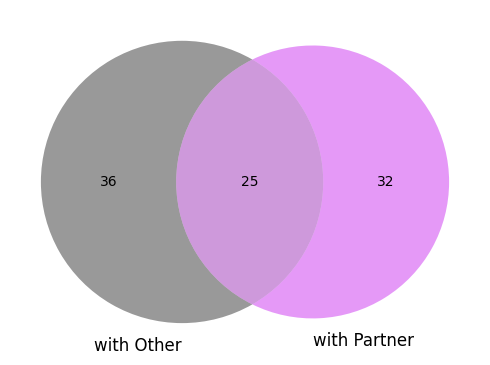

In [215]:
figure, ax = plt.subplots(1, 1, figsize=[5, 5])
set1 = set(df[df.withw=='Other'].id)
set2 = set(df[df.withw=='Partner'].id)
venn_labels = {'100': f'Total Set 1: {len(set1)}', '010': f'Total Set 2: {len(set2)}', '001': f'Shared: {len(set1 & set2)}'}    
venn2(subsets=(len(set1 - set2), len(set2 - set1), len(set1 & set2)), set_labels=('with Other', 'with Partner'), set_colors=('#000000', '#be00ed'))
plt.tight_layout()
plt.savefig("Graphs/venndiagram.pdf", dpi=1000)
plt.show()

In [225]:
both = set1 & set2
df[(df.withw == 'Other') & (~df.id.isin(both))]['hh_not'].value_counts(normalize=True)

hh_not
10.0    0.058333
16.0    0.054167
15.0    0.050000
14.5    0.045833
21.5    0.045833
10.5    0.045833
11.5    0.045833
19.0    0.041667
16.5    0.041667
11.0    0.041667
17.0    0.037500
20.5    0.037500
21.0    0.037500
15.5    0.037500
18.0    0.033333
22.0    0.033333
14.0    0.029167
18.5    0.029167
12.5    0.029167
12.0    0.029167
17.5    0.029167
20.0    0.025000
19.5    0.025000
9.5     0.025000
23.5    0.012500
22.5    0.012500
13.0    0.012500
23.0    0.008333
13.5    0.008333
7.0     0.008333
9.0     0.008333
0.5     0.008333
0.0     0.008333
5.5     0.004167
Name: proportion, dtype: float64

# Minute counts for user #1, Lecture days

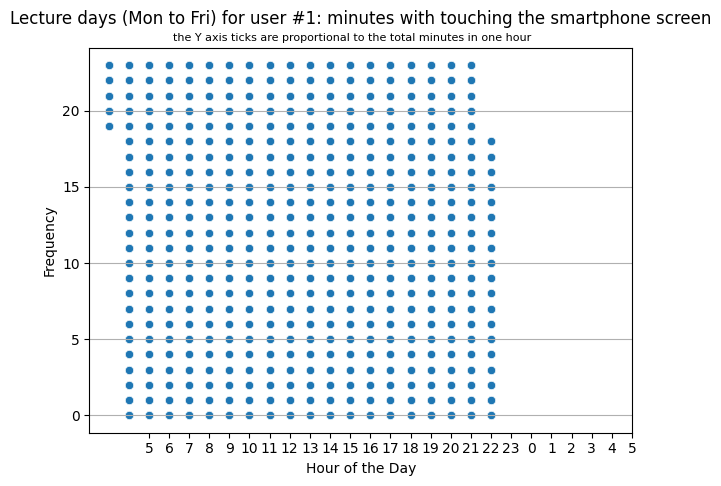

In [35]:
g = by_minute.copy()

g.loc[:,'using_phone'] = g['touches'] == 0
g.loc[:,'hour'] = g['timestamp'].dt.hour - 5
g.loc[:,'hour'] = [today_or_yesterday(hour) for hour in g['hour']]
g.loc[:, 'by_minute'] = g.loc[:,'hour'] + round(g.loc[:,'timestamp'].dt.minute/60, 3)
g

f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)
custom_order = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5]

sns.scatterplot(data=g[g['using_phone'] == True],
               x = 'day',
               y = 'hour'
             # palette=sns.color_palette(["#1e0f59", "#d4fbff"])
            )


ax.grid(axis='y')
plt.xticks(np.arange(len(custom_order)), custom_order)
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.title('Lecture days (Mon to Fri) for user #1: minutes with touching the smartphone screen', y=1.04)
plt.suptitle("the Y axis ticks are proportional to the total minutes in one hour", y=0.91, ha='center', fontsize=8)
# plt.legend()
plt.savefig('one_user_lectdays.png')
plt.show()

# Minute counts for user #1, Weekends

/tmp/ipykernel_7059/2259965085.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g['using_phone'] = g['touches'] >= 1
/tmp/ipykernel_7059/2259965085.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  g['hour'] = g['timestamp'].dt.hour - 5
/tmp/ipykernel_7059/2259965085.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

NameError: name 'mticker' is not defined

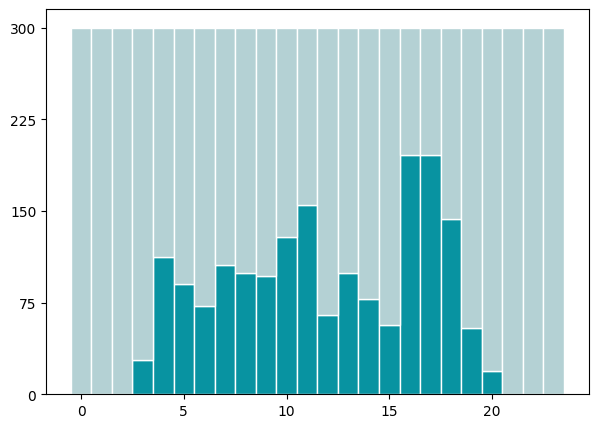

In [36]:
g = by_minute[(by_minute.id==1) & (by_minute.day.isin(weekends))]

g['using_phone'] = g['touches'] >= 1 
g['hour'] = g['timestamp'].dt.hour - 5
g['hour'] = [today_or_yesterday(hour) for hour in g['hour']]

f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)

ax.hist([g['hour'][g['using_phone'] == 1], g['hour'][g['using_phone'] == 0]],
         
         bins=np.arange(-0.5, len(custom_order) - 0.5, 1),
         color=["#0893a1", "#b4d1d4"],
         edgecolor='white', stacked=True, label=['touchscreen events', 'no touchscreen event'])

n = g[g.hour == 10].shape[0]
plt.yticks([0, n/4,n/2, n-n/4, n])
ax.yaxis.set_major_formatter(mticker.PercentFormatter(n))
ax.grid(axis='y')
plt.xticks(np.arange(len(custom_order)), custom_order)
plt.xlabel('Hour of the Day')
plt.title('Weekends (Sat, Sun) for user #1: minutes with touching the smartphone screen', y=1.04)
plt.suptitle("the Y axis ticks are proportional to the total minutes in one hour", y=0.91, ha='center', fontsize=8)
plt.ylabel('Frequency')
plt.legend()
plt.savefig('one_user_weekends.png')
plt.show()

# Lecture days, but the minute counts represent all 147 users

In [ ]:
g = by_minute[~by_minute.day.isin(weekends)]
g['using_phone'] = g['touches'] == 0
g['hour'] = g['timestamp'].dt.hour - 5

g['hour'] = [today_or_yesterday(hour) for hour in g['hour']]
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)
custom_order = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 0, 1, 2, 3, 4, 5]

ax.hist([g['hour'][g['using_phone'] == 0], g['hour'][g['using_phone'] == 1]],
         bins=np.arange(-0.5, len(custom_order) - 0.5, 1),
         edgecolor='white', stacked=True, label=['touchscreen events', 'no touchscreen event'],
        color=["#0893a1", "#b4d1d4"])
n = g[g.hour == 10].shape[0]
plt.yticks([0, n/4,n/2, n-n/4, n])
ax.yaxis.set_major_formatter(mticker.PercentFormatter(n))
ax.grid(axis='y')
plt.xticks(np.arange(len(custom_order)), custom_order)
plt.xlabel('Hour of the Day')
plt.ylabel('Frequency')
plt.title('Lecture days (Mon to Fri) for user #1: minutes with touching the smartphone screen', y=1.04)
plt.suptitle("the Y axis ticks are proportional to the total minutes in one hour", y=0.91, ha='center', fontsize=8)
plt.legend()
plt.savefig('all_users_lectdays.png')
plt.show()

# Weekends, but minute counts represent all users

In [ ]:
g = by_minute[by_minute.day.isin(weekends)]
g['using_phone'] = g['touches'] >= 1 
g['hour'] = g['timestamp'].dt.hour - 5
g['hour'] = [today_or_yesterday(hour) for hour in g['hour']]
f = plt.figure(figsize=(7,5))
ax = f.add_subplot(1,1,1)
ax.hist([g['hour'][g['using_phone'] == 1], g['hour'][g['using_phone'] == 0]],
        bins=np.arange(-0.5, len(custom_order) - 0.5, 1), color=["#0893a1", "#b4d1d4"], 
        edgecolor='white', stacked=True, label=['touchscreen events', 'no touchscreen event'])
n = g[g.hour == 10].shape[0]
plt.yticks([0, n/4,n/2, n-n/4, n])
ax.yaxis.set_major_formatter(mticker.PercentFormatter(n))
ax.grid(axis='y')
plt.xticks(np.arange(len(custom_order)), custom_order,rotation=90)
plt.xlabel('Hour of the Day')
plt.title('Weekends (Sat, Sun) for all users: minutes with touching the smartphone screen', y=1.04)
plt.suptitle("the Y axis ticks are proportional to the total minutes in one hour", y=0.91, ha='center', fontsize=8)
plt.ylabel('Frequency')
plt.legend()
plt.savefig('all_users_weekends.png')
plt.show()

# Population-level comparison between lecture days and weekends

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(9, 7), sharex=True)
ax1 = axes[0]
ax2 = axes[1]

#LECTURE DAYS:
g = by_minute[~by_minute.day.isin(weekends)]
g['using_phone'] = g['touches'] >= 1 
g['hour'] = g['timestamp'].dt.hour - 5
g['hour'] = [today_or_yesterday(hour) for hour in g['hour']]

ax1.hist([g['hour'][g['using_phone'] == 1], g['hour'][g['using_phone'] == 0]],bins=np.arange(-0.5, len(custom_order) - 0.5, 1), 
         color=["#0893a1", "#ffffff"], edgecolor='white', stacked=True, label=['touchscreen events', 'no touchscreen event'])
n = g[g.hour == 10].shape[0]

ax1.set_yticks(     [0, n*0.05, n*0.1, n*0.15, n*0.2, n/4, n*0.3, n/2, n*0.75, n])
ax1.set_yticklabels([' ', '5%','10%', '15%', '20%', '25%', '30%','50%', '75%', '100%'])
ax1.grid(axis='y')
ax1.set_title(f"Monday to Friday, n = {g.userid.unique().shape[0]}", y = 1)

ax1.set_ylim(0, n*0.3)


# WEEKENDS:
g = by_minute[by_minute.day.isin(weekends)]
g['using_phone'] = g['touches'] >= 1 
g['hour'] = g['timestamp'].dt.hour - 5
g['hour'] = [today_or_yesterday(hour) for hour in g['hour']]

ax2.hist([g['hour'][g['using_phone'] == 1], g['hour'][g['using_phone'] == 0]],bins=np.arange(-0.5, len(custom_order) - 0.5, 1), 
         color=["#0893a1", "#ffffff"], edgecolor='white', stacked=True, label=['touchscreen events', 'no touchscreen event'])
n = g[g.hour == 10].shape[0]

ax2.set_yticks([0, n*0.05, n*0.1, n*0.15, n*0.2, n/4, n*0.3, n/2, n-n/4, n])
ax2.set_yticklabels([' ', '5%','10%', '15%', '20%', '25%', '30%','50%', '75%', '100%'])
ax2.grid(axis='y')
ax2.set_title(f"Saturday and Sunday, n = {g.userid.unique().shape[0]}", y = -0.3)
ax2.set_xticks(np.arange(len(custom_order)))
ax2.set_xticklabels(custom_order)
ax2.set_xlim(-0.5, 23.5)

ax2.set_ylim(0, n*0.3)


plt.subplots_adjust(hspace=0.038, wspace=0.2)

plt.xlabel('Hour of the Day')
#plt.title('Weekends (Sat, Sun) for all users: minutes with touching the smartphone screen', y=1.04)
#plt.suptitle("the Y axis ticks are proportional to the total minutes in one hour", y=0.91, ha='center', fontsize=8)
plt.ylabel('Frequency')
plt.legend(loc='upper right', prop={'size': 7})
plt.savefig("test.png")
plt.show()

In [ ]:
for user in lectures_data.userid.unique():
    if user not in demographics.userid.unique():
        print(user)

In [ ]:
lectures_data = by_minute[~by_minute.day.isin(weekends)]
weekend_data = by_minute[by_minute.day.isin(weekends)]

In [ ]:
lectures_data[(lectures_data.userid == 1)].touches.sum()
g = lectures_data.groupby(by='userid').touches.agg('sum').sort_values().reset_index()
g.userid = g.userid.astype(str)
g
fig = plt.subplots(1, 1, figsize=(15,10))
sns.scatterplot(x='userid', y='touches', data=g)
plt.tick_params(axis='x', labelsize=5)
plt.xticks(rotation=90)

plt.show()
